In [3]:
!ls /home/tungnguyendinh/.fastai/data/pascal_2007/

segmentation  test.csv	 train	    train.json
test	      test.json  train.csv  valid.json


In [1]:
import os
import sys

import torch
import torchvision
import torchvision.transforms as tvtf
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from typing import Tuple

In [2]:
# automatically reloads external files
%load_ext autoreload
%autoreload 2

In [3]:
data_path = '/home/tungnguyendinh/.fastai/data/pascal_2007/'

## 1. Setup the data


### Modifying Labels
- Since we are performing Multi-label classification, we need to make a few adjustments:
    - change label from a single scalar (representing the class) to an `n_classes` binary vector, indicating all present classes.
    - other changes which will be covered later

In [4]:
VOC_CLASSES = (
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant', 
    'sheep', 'sofa', 'train', 'tvmonitor'
)

In [5]:
def encode_label(labels, classes=VOC_CLASSES):
    '''
    Takes a list of label names as input, encodes them into a binary tensor:
        - Same length as len(VOC_CLASSES)
        - Each element represents the presence (1) or absence (0) of a specific class
        
    '''
    target = torch.zeros(len(classes))
    for l in labels:
        idx = classes.index(l)
        target[idx] = 1 # 1 if label is present 
    
    return target


def decode_target(target, threshold=0.5, classes=VOC_CLASSES):
    '''
    Input: Tensor that represents class confidence score (Sigmoid, not Softmax)
    If score >= threshold, the corresponding class score (classes) is added to label results, 
        which is returned.
    '''
    results = []
    
    for idx, cls_score in enumerate(target):
        if (cls_score >= threshold):
            results.append(classes[idx])
            
    return ' '.join(results)
        


In [6]:
class PascalVOCDataset(Dataset):
    def __init__(self, data_path, csv_file, transform=None, is_test=False, is_valid=False):
        self.data_path = data_path
        self.csv_file = csv_file
        self.transform = transform
        self.is_test = is_test

        # load CSV file containing annotations
        self.annotations = pd.read_csv(os.path.join(data_path, csv_file)) # N * 3

        # filter validation data based on 'is_valid' column
        if is_test:
            pass
        else:
            if is_valid:
                self.annotations = self.annotations[self.annotations['is_valid']==True]
            else:
                self.annotations = self.annotations[self.annotations['is_valid']==False]

    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, str]:
        # get image filename and label at specified index:
        img_filename = self.annotations.iloc[index, 0]
        label = self.annotations.iloc[index, 1].split(' ')
        
        # load image
        img_path = os.path.join(self.data_path, 'train', img_filename) if not self.is_test else os.path.join(self.data_path, 'test', img_filename)
        img = Image.open(img_path).convert('RGB')

        # apply transformations
        if self.transform:
            img = self.transform(img)
        
        return img, encode_label(label)
        

### Transforms
- Train and eval/test get different transformations

In [7]:
mean = [.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


train_transform = tvtf.Compose([
    tvtf.Resize((300, 300)),
    tvtf.RandomCrop((256, 256)),
    tvtf.RandomHorizontalFlip(p=0.2),
    tvtf.ToTensor(),
    tvtf.Normalize(mean=mean, std=std)
])

eval_test_transform = tvtf.Compose([
    tvtf.Resize((300, 300)),
    tvtf.CenterCrop((256, 256)),
    tvtf.RandomHorizontalFlip(p=0.25),
    tvtf.ToTensor(),
    tvtf.Normalize(mean=mean, std=std)
])



# train_ds
ds_train = PascalVOCDataset(data_path, 'train.csv', transform=train_transform, is_test=False, is_valid=False)

# valid_ds
ds_valid = PascalVOCDataset(data_path, 'train.csv', transform=eval_test_transform, is_test=False, is_valid=True)

# test_ds
ds_test = PascalVOCDataset(data_path, 'test.csv', transform=eval_test_transform, is_test=True, is_valid=False)



### DataLoader

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 68
num_workers = 2

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers) 
dl_valid = DataLoader(ds_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

## Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


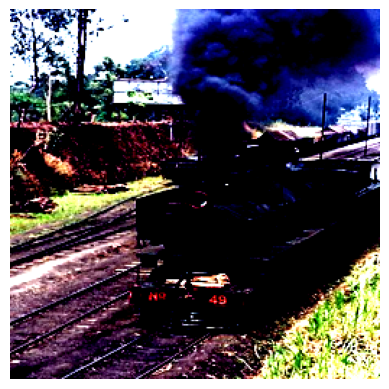

In [9]:
def plot_img(ds, index: int):
    image = ds[index][0].numpy().transpose((1, 2, 0)) # c, h, w -> h, w, c
    plt.imshow(image)
    plt.axis('off')
    plt.show()


plot_img(ds_train, 6)

In [10]:
def plot_multiple(ds):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3

    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(ds), size=(1, )).item()
        img, label = ds[sample_idx]
        figure.add_subplot(rows, cols, i)

        title = f'{decode_target(label)}'
        plt.title(title)
        plt.axis('off')
        plt.imshow(img.squeeze().permute(1, 2, 0), cmap='gray')
    
    plt.show();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


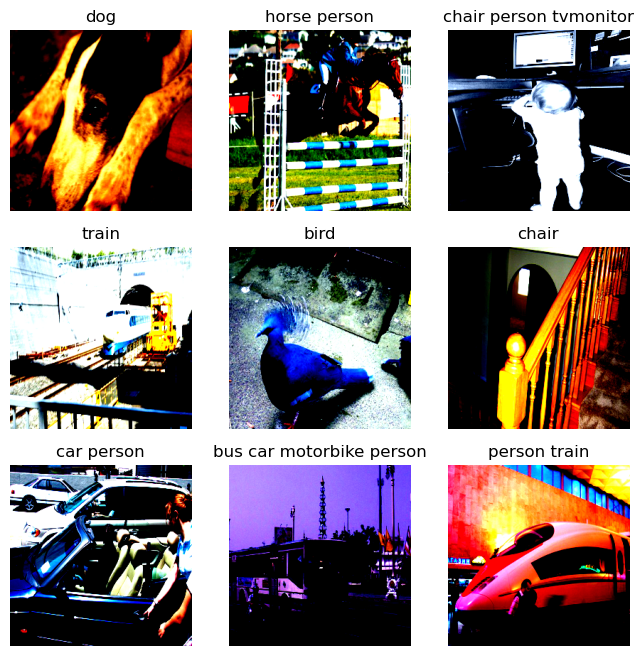

In [11]:
plot_multiple(ds_train)

### Modeling  
#### ViT 

In [12]:
import torch.nn as nn
from vit_pytorch import ViT 

In [13]:
class ViTMultiLabelClassifier(nn.Module):
    def __init__(self, num_classes, image_size, patch_size, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        self.vit = ViT(
            image_size = image_size,
            patch_size = patch_size,
            num_classes = num_classes,
            dim = dim,
            depth = depth,
            heads = heads,
            mlp_dim = mlp_dim,
            channels = channels
        )
        
        #self.fc = nn.Linear(dim, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, X):
        # forward through ViT
        X = self.vit(X)
        
        # class scores (Sigmoid for multi-label classification)
        X = self.sigmoid(X)
        
        return X
    

In [14]:
# hyper params
num_classes = len(VOC_CLASSES)
image_size = 256
patch_size = 32
dim = 384
depth = 4
heads = 4
mlp_dim = 512

myViT = ViTMultiLabelClassifier(num_classes, image_size, patch_size, dim, depth, heads, mlp_dim)

print(myViT)

ViTMultiLabelClassifier(
  (vit): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
      (1): Linear(in_features=3072, out_features=384, bias=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (transformer): Transformer(
      (layers): ModuleList(
        (0-3): 4 x ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (attend): Softmax(dim=-1)
              (to_qkv): Linear(in_features=384, out_features=768, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=256, out_features=384, bias=True)
                (1): Dropout(p=0.0, inplace=False)
              )
            )
          )
          (1): PreNorm(
            (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
            (fn): FeedForward(
              (net): Sequential(
                (0): Linear(i

In [15]:
total_params = sum(p.numel() for p in myViT.parameters())

print(total_params)

4370836


In [16]:
!export CUDA_LAUNCH_BLOCKING=1 

In [17]:
# TEST RUN
import torch.optim as optim
from tqdm import tqdm

# criterion = nn.BCELoss()
# optimizer = optim.Adam(myViT.parameters(), lr=0.001)

# for epoch in range(2):
#     model.train()
#     train_loss = 0
    
#     for X, y in tqdm(dl_train, desc=f'Epoch {epoch + 1}'):
#         X, y = X.to(device), y.to(device)
        
#         optimizer.zero_grad()
#         outputs = model(X)
        
#         loss = criterion(outputs, y)
#         loss.backward()
        
#         optimizer.step()
        
#         train_loss += loss.item() * X.size(0)

#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for X, y in tqdm(dl_valid, desc='Validation'):
#             X, y = X.to(device), y.to(device)
#             outputs = model(X)
            
#             loss = criterion(outputs, y)
#             val_loss += loss.item() * X.size(0)
        

In [18]:
from training import ViTTrainer
from classifier import MultiLabelClassifier


In [19]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda:3

NVIDIA GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [20]:


# myModel = MultiLabelClassifier(myViT, threshold=0.5)

# loss_fn = nn.BCELoss()
# optimizer = torch.optim.SGD(myModel.parameters(), lr=1e-2, momentum=0.9)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 12, eta_min=0, last_epoch=-1)

# trainer = ViTTrainer(myModel, loss_fn, optimizer, device)
#fit_result = trainer.fit(dl_train, dl_valid, num_epochs=15, print_every=1)


In [21]:
# def train(dataloader, model, loss_fn, optimizer, epoch):
#     size = len(dataloader.dataset)
#     model.train()
#     for batch, (X, y) in enumerate(dataloader):
#         X, y = X.to(device), y.to(device)

#         pred = model(X)
#         loss = loss_fn(pred, y)
        
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if (batch % 50 == 0):
#             loss, current = loss.item(), (batch + 1) * len(X)
#             tmp_pred = nn.Sigmoid()(pred).detach()
#             tmp_y = y.detach()
#             curr_acc, curr_hl = Accuracy_n_HammingScore(y_pred=tmp_pred, y_true=tmp_y)
#             del tmp_pred, tmp_y
#             print(f"loss: {loss:>7f}, training accuracy: {100*curr_acc:>0.1f}%, hamming score: {100*curr_hl:>0.1f}% Data: [{current:>5d}/{size:>5d}]")
#     eval(dl_train, model, loss_fn, epoch, mode = "train")
    

# def eval(dataloader, model, loss_fn, epoch, mode = "test"):
#     num_batches = len(dataloader)
#     model.eval()
#     eval_loss, hl, acc = 0, 0, 0
#     with torch.no_grad():
#         for X, y in dataloader:
#             X, y = X.to(device), y.to(device)
#             out = model(X)
#             eval_loss += loss_fn(out, y).item()
#             out = nn.Sigmoid()(out)
#             tmp_acc, tmp_hl = Accuracy_n_HammingScore(y_pred=out, y_true=y)
#             hl += tmp_hl
#             acc += tmp_acc
#             del tmp_hl, tmp_acc
#     eval_loss /= num_batches
#     hl /= num_batches  # Accuracy for whole epoch
#     acc /= num_batches
#     print(f"{mode} Error: \n Accuracy: {(100*acc):>0.1f}%, hamming score: {100*hl:>0.1f}%, Avg loss: {eval_loss:>8f} \n")

In [22]:
# epochs = 10
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train(dl_train, myModel, loss_fn, optimizer, t)
#     scheduler.step()
#     eval(dl_valid, myModel, loss_fn, t, mode = 'validation')
# print("Done!")
# #torch.save(model.state_dict(), f'runs/{name}/model.pth')

In [23]:
model = torchvision.models.resnet50(pretrained=True)

/home/hiepphamduc/miniconda3/envs/torch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hiepphamduc/miniconda3/envs/torch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
for p in model.parameters():
    p.requires_grad = False
    
model.avgpool = torch.nn.AdaptiveAvgPool2d(1)
model.fc = nn.Sequential(nn.Dropout(0,2),
                         nn.Linear(model.fc.in_features, 20))

model = MultiLabelClassifier(model, threshold=0.5)

In [ ]:

loss_fn = nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.SGD([
    {'params': list(model.parameters())[:-1], 'lr': 1e-4, 'momentum':0.9},
    {'params': list(model.parameters())[-1], 'lr': 5e-2, 'momentum': 0.9}
])

trainer = ViTTrainer(model, loss_fn, optimizer, device)
fit_result = trainer.fit(dl_train, dl_valid, num_epochs=7, print_every=1)

--- EPOCH 1/7 ---


train_batch:   0%|          | 0/37 [00:00<?, ?it/s]

test_batch:   0%|          | 0/37 [00:00<?, ?it/s]

--- EPOCH 2/7 ---


train_batch:   0%|          | 0/37 [00:00<?, ?it/s]

test_batch:   0%|          | 0/37 [00:00<?, ?it/s]

--- EPOCH 3/7 ---


train_batch:   0%|          | 0/37 [00:00<?, ?it/s]

test_batch:   0%|          | 0/37 [00:00<?, ?it/s]

--- EPOCH 4/7 ---


train_batch:   0%|          | 0/37 [00:00<?, ?it/s]

test_batch:   0%|          | 0/37 [00:00<?, ?it/s]

--- EPOCH 5/7 ---


train_batch:   0%|          | 0/37 [00:00<?, ?it/s]

test_batch:   0%|          | 0/37 [00:00<?, ?it/s]

--- EPOCH 6/7 ---


train_batch:   0%|          | 0/37 [00:00<?, ?it/s]

test_batch:   0%|          | 0/37 [00:00<?, ?it/s]

--- EPOCH 7/7 ---


train_batch:   0%|          | 0/37 [00:00<?, ?it/s]

test_batch:   0%|          | 0/37 [00:00<?, ?it/s]

In [ ]:
plt.plot(fit_result.train_loss)

In [ ]:
model.eval()
eval_loss, correct = 0, 0
i = 0
low_acc_lst = None
with torch.no_grad():
    for X, y in dl_test:
        X, y = X.to(device), y.to(device)
        out = model(X)
        out = nn.Sigmoid()(out)
        if i == 0:
            low_acc_lst = out
        else:
            low_acc_lst = torch.cat((low_acc_lst, out))    
        i += 1
        if i == 50:
            break
inv_normalize = tvtf.Normalize(
    mean= [-m for m in mean],
    std= [1/s for s in std]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


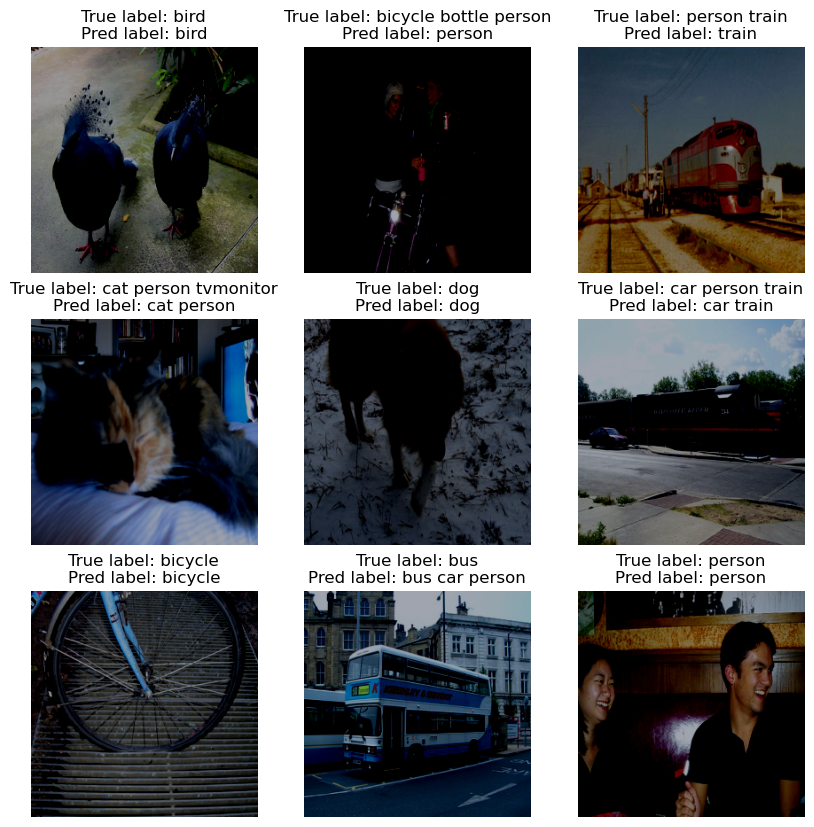

In [37]:
sample_idx = 10

figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(low_acc_lst), size=(1,)).item()
    img, label = ds_test[sample_idx]
    img, label = img.to("cpu"), label.to("cpu")
    img = inv_normalize(img)
    figure.add_subplot(rows, cols, i)
    true_label = decode_target(label)
    pred_label = decode_target(low_acc_lst[sample_idx])
    title = f"True label: {true_label}\nPred label: {pred_label}"
    plt.title(title)
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1, 2, 0), cmap="gray")
plt.show()